**Classification of sign language hand gestures
with CNN**

---

**Overview** - In this project we will try to teach the computer to identify the alphabetic meaning in sign language of a hand gesture .

**Goal** - We want the computer to identify the alphabetic meaning of a hand gesture in the picture, and that when it gets a new picture, it would know to match the hand gesture to the coresponding letter that it represents. 
Our data consists pictures of letters from A-Y excluding J , so we will not learn on 'Z' and 'J'

**Learning process** - We would first get dataset of pictures and some CSV files that include information about the bounding boxes for the pictures , the bounding boxes are indexes that we can use to crop the pictures and focus only at the hand in the picture. 
We will crop the pictures according to their bounding boxes.
We will divide our data to training set and testing set.
The learning would be implemented using a Neural network, we would try to reach accuracy of at least 85% on the testing set.
Our network would train on the training set.

**Validation process** - The computer will test it's accuracy on the testing set (which was not part of the training set) and check how close his prediction is to the actual labels of the pictures.

**Import declarations**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import csv
from os import listdir
from os.path import join
import random
from PIL import Image
import zipfile
import os
from skimage.transform import resize
import urllib
import keras
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


** Constants declaration**

In [0]:
included_extensions = 'jpg'
data_url = 'https://github.com/yoavram/Sign-Language/raw/master/Dataset.zip'
directory = './Dataset'
data_filename = './Dataset.zip'
CSV_postfix = 'csv'

**Function declarations**

In [0]:
# load zip file

def loadZip(data_url=data_url,data_filename=data_filename):
    if not os.path.exists(data_filename):
        urllib.request.urlretrieve(data_url, data_filename)
    print("Data file exists:", os.path.exists(data_filename))

In [0]:
#extract zip data to directory

def extractZip(data_filename=data_filename):
    zip_ref = zipfile.ZipFile(data_filename, 'r')
    zip_ref.extractall()
    zip_ref.close()


In [0]:
# add cropped JPGs and labels to list

def createCroppedList(directory=directory):
    croppedArray = []
    labels = []
    dictionary = dict()
    for user in os.listdir(directory):
        for file in os.listdir(os.path.join(directory,user)):
            if file.endswith(CSV_postfix):
                data = pd.read_csv(os.path.join(directory,user,file))
                for _, row in data.iterrows():
                    boundarybox = row['top_left_x'], row['bottom_right_x'], row['top_left_y'], row['bottom_right_y']
                    cropped_image = preProcess(open(os.path.join(directory,row['image'])),boundarybox)
                    croppedArray.append(cropped_image)
                    labels.append(row['image'][-6])
                    if row['image'][-6] in dictionary:
                      dictionary[row['image'][-6]].append(cropped_image)
                    else:
                      dictionary[row['image'][-6]] = []
    for key in dictionary:
      dictionary[key] = np.array(dictionary[key])
    return np.array(croppedArray),np.array(labels),dictionary



In [0]:
# Cropping and resizing
def preProcess(image,box):
    image = np.array(Image.open(image.name))
    cropped= image[box[2]:box[3],box[0]:box[1]]
    cropped= resize(cropped,((128,128)))
    return cropped

In [0]:
def init():
    loadZip()
    extractZip()
    return createCroppedList()

In [0]:
def setLabelsToIntType(labels):
    int_labels = []
    for c in labels:
        int_labels.append(ord(c)-65 if ord(c)<75 else ord(c)-66)
    return np.array(int_labels)

In [0]:
def oneHotEncoding(labels):
    nsamples = len(labels)
    Y = np.zeros((nsamples, len(np.unique(labels))))
    Y[np.arange(nsamples), setLabelsToIntType(labels)] = 1
    return Y

In [0]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

In [0]:
def decode(prediction):
    max_index = prediction.argmax()
    prediction = str(chr(max_index + 65)) if max_index < 9 else str(chr(max_index + 66)) 
    return prediction

**Start code run**

In [12]:
#preprocess data 

croppedList, labels, dictionary = init()

Data file exists: True


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
# one hot encoding of the data, test-train splitting and getting number of classes

nclasses = len(np.unique(labels))
labels = oneHotEncoding(labels)
X_train, X_test , Y_train , Y_test = train_test_split(croppedList, labels,test_size=0.25)

In [14]:
# building the model 

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(64, (3, 3)))
model.add(keras.layers.Activation( 'relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(128, (3, 3)))
model.add(keras.layers.Activation( 'relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(nclasses))
model.add(keras.layers.Activation('softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# using ADAM optimizer for the model

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [16]:
# train the model 

history = model.fit(
    X_train, Y_train,
    batch_size=50,
    epochs=15,
    validation_data=(X_test, Y_test)
).history

Instructions for updating:
Use tf.cast instead.
Train on 1260 samples, validate on 420 samples
Epoch 1/15
1260/1260 [==============================] - 70s 56ms/step - loss: 3.3366 - acc: 0.0563 - val_loss: 3.0785 - val_acc: 0.2119
Epoch 2/15
1260/1260 [==============================] - 67s 53ms/step - loss: 2.5740 - acc: 0.2429 - val_loss: 1.8560 - val_acc: 0.4595
Epoch 3/15
1260/1260 [==============================] - 69s 55ms/step - loss: 1.6959 - acc: 0.4556 - val_loss: 1.1947 - val_acc: 0.6024
Epoch 4/15
1260/1260 [==============================] - 68s 54ms/step - loss: 1.2114 - acc: 0.5960 - val_loss: 0.8482 - val_acc: 0.6952
Epoch 5/15
1260/1260 [==============================] - 68s 54ms/step - loss: 0.9320 - acc: 0.6960 - val_loss: 0.7931 - val_acc: 0.7452
Epoch 6/15
1260/1260 [==============================] - 68s 54ms/step - loss: 0.7961 - acc: 0.7325 - val_loss: 0.6624 - val_acc: 0.7857
Epoch 7/15
1260/1260 [==============================] - 68s 54ms/step - loss: 0.5804 - ac

In [17]:
# Score trained model.

loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

420/420 [==============================] - 6s 13ms/step
Test loss: 0.3186642221751667
Test accuracy: 0.8833333333333333


In [0]:
# choose 9 random pictures

samples_idx = np.random.choice(len(croppedList),9)
X_samples = croppedList[samples_idx]
Y_labels = labels[samples_idx]
X_prediction = model.predict(X_samples)

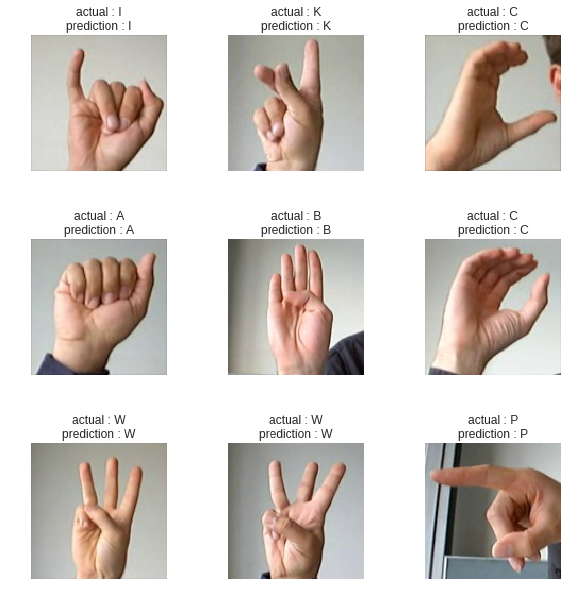

In [19]:
# plot the 9 random pictures with the actual letter and the predicted one


plt.figure(figsize=[10,10])
plt.subplots_adjust(hspace = 0.5) 

for i in range(len(Y_labels)):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(X_samples[i])
    plt.title('actual : {}'.format(decode(Y_labels[i])) + '\nprediction : {}'.format(decode(X_prediction[i])))

In [0]:
# calculate accuracies by class type

accuracies = []

for key, value in dictionary.items():
  predicted = [decode(model.predict(value[i:i+1])) for i in range(len(value))]
  accuracy = predicted == np.array(key)
  accuracies.append(accuracy.mean())
  
accuracies = np.array(accuracies)

Text(0.5, 1.0, 'Accuracy per class (%)')

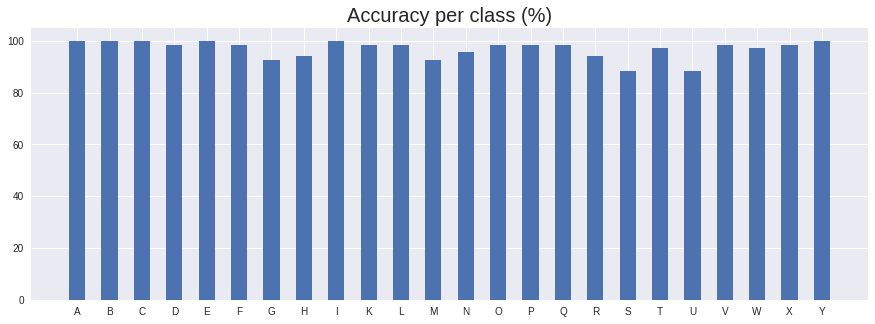

In [21]:
# plot bar for classes

plt.figure(figsize=(15, 5))
plt.bar(dictionary.keys(), height = (accuracies*100) ,align='center', width=0.5)
plt.title('Accuracy per class (%)' , fontsize=20)

**End**